# Editing graph state

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state

We showed how breakpoints support user approval, but don't yet know how to modify our graph state once our graph is interrupted!

## Goals

Now, let's show how to directly edit the graph state and insert human feedback.

In [21]:
%%capture --no-stderr
%pip install --quiet -U langgraph langgraph_sdk langgraph-prebuilt

In [22]:
%pip install -qU 'langchain[google-genai]'

In [23]:
import os, getpass
def _set_env(var: str):
  if not os.environ.get(var):
    os.environ[var] = getpass.getpass(f"{var}")
_set_env("GOOGLE_API_KEY")

## Editing state

Previously, we introduced breakpoints.

We used them to interrupt the graph and await user approval before executing the next node.

But breakpoints are also [opportunities to modify the graph state](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/edit-graph-state/).

Let's set up our agent with a breakpoint before the `assistant` node.

In [24]:
from langchain_google_genai import ChatGoogleGenerativeAI
def multiply(a: int, b: int) -> int:
  """Multiply a and b

  Args:
      a: first int
      b: second int
  """
  return a * b

def add(a: int, b: int) -> int:
  """Adds a and b

  Args:
      a: first int
      b: second int
  """
  return a + b

def divide(a: int, b: int) -> int:
  """Multiply a and b

  Args:
      a: first int
      b: second int
  """
  return a / b

tools = [add, multiply, divide]
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash",temperature=0)
llm_with_tools = llm.bind_tools(tools)

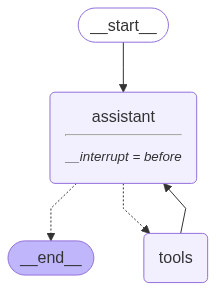

In [25]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
  return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


Let's run!

We can see the graph is interrupted before the chat model responds.

In [26]:
# Input
initial_input = {"messages":"Multiply 2 and 3"}

# Thread
thread = {"configurable":{"thread_id":"1"}}

# Run the Graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
  event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [27]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='e984fca8-66ab-41ed-b22a-6ac31bd6f05c')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f084d1d-71ce-6319-8000-a33e6edd1c99'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-29T12:15:24.051103+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f084d1d-71cb-65c0-bfff-f41ce6cd3874'}}, tasks=(PregelTask(id='1468f5ce-5b94-dfe3-1eb5-ad4b8c3502a3', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

Now, we can directly apply a state update.

Remember, updates to the `messages` key will use the `add_messages` reducer:

* If we want to over-write the existing message, we can supply the message `id`.
* If we simply want to append to our list of messages, then we can pass a message without an `id` specified, as shown below.

In [28]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f084d1d-7220-60ba-8001-b0988658a83a'}}

Let's have a look.

We called `update_state` with a new message.

The `add_messages` reducer appends it to our state key, `messages`.

In [29]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
  m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


Now, let's proceed with our agent, simply by passing `None` and allowing it proceed from the current state.

We emit the current and then proceed to execute the remaining nodes.

In [30]:
for event in graph.stream(None, thread, stream_mode="values"):
  event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (f8693097-d676-4db9-ae4f-64fe815889eb)
 Call ID: f8693097-d676-4db9-ae4f-64fe815889eb
  Args:
    a: 3.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

9


Now, we're back at the `assistant`, which has our `breakpoint`.

We can again pass `None` to proceed.

In [31]:
for event in graph.stream(None, thread, stream_mode="values"):
  event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

I have multiplied 3 and 3, and the answer is 9.
